### Text Summarization with RAG

In [6]:
from langchain_community.llms import Ollama
#from langchain_openai.chat_models import ChatOpenAI
from langchain_community.embeddings import OllamaEmbeddings
#from langchain_openai.embeddings import OpenAIEmbeddings

In [7]:
MODEL = "llama2"

In [8]:
model = Ollama(model=MODEL)

In [9]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

chain = model | parser 

In [10]:
from langchain.prompts import PromptTemplate

template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know". 

Context: {context}

Question: {question}
"""

prompt = PromptTemplate.from_template(template)
prompt.format(context="Here is some context", question="Here is a question")

'\nAnswer the question based on the context below. If you can\'t \nanswer the question, reply "I don\'t know". \n\nContext: Here is some context\n\nQuestion: Here is a question\n'

In [11]:
chain = prompt | model | parser

In [12]:
from langchain_community.document_loaders import TextLoader

# Specify the encoding as 'utf-8'
loader = TextLoader("Data/alice_wonderland_chapter1.txt", encoding='utf-8')
pages = loader.load_and_split()
pages


[Document(page_content='Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?”\n\nSo she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.\n\nThere was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-po

In [3]:
from langchain_community.vectorstores import DocArrayInMemorySearch
embeddings = OllamaEmbeddings(model=MODEL)
vectorstore = DocArrayInMemorySearch.from_documents(pages, embedding=embeddings)

C:\Users\yashi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydantic\_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [13]:
retriever = vectorstore.as_retriever()

In [14]:
from operator import itemgetter

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | model
    | parser
)

In [15]:
questions = [
    "Summarize this book. Use only the text within this book for generating the summary. Write the summary in 1000 words."
]

for question in questions:
    print(f"Question: {question}")
    print(f"Answer: {chain.invoke({'question': question})}")
    print()

Question: Summarize this book. Use only the text within this book for generating the summary. Write the summary in 1000 words.
Answer: Alice's Adventures in Wonderland is a fantastical tale of a young girl who falls down a rabbit hole and enters a strange and absurd world filled with illogical creatures and events. The story begins with Alice feeling bored and dissatisfied with her life at home, leading her to daydream about adventures in the countryside. Suddenly, she notices a white rabbit wearing a waistcoat running quickly down a nearby hill, prompting Alice to follow after it. She falls down a deep hole and finds herself in a subterranean area filled with twisting tunnels and dark caves. Alice encounters many strange creatures, including the Cheshire Cat, the Queen of Hearts, and the Mad Hatter. Each creature she meets presents her with absurd puzzles or games that challenge Alice's logic and reasoning. The most notable is the Queen of Hearts, who demands Alice play a game of croq

### Text Summarization with TextRank

Cosine Similarity

In [8]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt') # one time execution
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load text file
def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Tokenization and preprocessing
def preprocess_text(text):
    sentences = sent_tokenize(text)
    preprocessed_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        preprocessed_sentences.append(' '.join(tokens))
    return preprocessed_sentences


# Read text file
text = read_text('Data/alice_wonderland_chapter1.txt')

# Preprocess text
preprocessed_text = preprocess_text(text)


In [10]:
# Extract word vectors
word_embeddings = {}
f = open('glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()
len(word_embeddings)

1917495

In [11]:
sentence_vectors = []
for i in preprocessed_text:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()]) / (len(i.split()) + 0.001)
    else:
        v = np.zeros((300,))
    sentence_vectors.append(v)

# similarity matrix
sim_mat = np.zeros([len(preprocessed_text), len(preprocessed_text)])

In [12]:
# Define and initialize similarity matrix
sim_mat = np.zeros((len(preprocessed_text), len(preprocessed_text)))

# Compute cosine similarity between pairs of sentences
for i in range(len(preprocessed_text)):
    for j in range(len(preprocessed_text)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1, 300), sentence_vectors[j].reshape(1, 300))[0, 0]


In [13]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [14]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(preprocessed_text)), reverse=True)

In [15]:
# Extract top 10 sentences as the summary
for i in range(10):
  print(ranked_sentences[i][1])

Let me see : that would be four thousand miles down , I think— ” ( for , you see , Alice had learnt several things of this sort in her lessons in the schoolroom , and though this was not a very good opportunity for showing off her knowledge , as there was no one to listen to her , still it was good practice to say it over ) “ —yes , that ’ s about the right distance—but then I wonder what Latitude or Longitude I ’ ve got to ? ” ( Alice had no idea what Latitude was , or Longitude either , but thought they were nice grand words to say . )
I shall be late ! ” ( when she thought it over afterwards , it occurred to her that she ought to have wondered at this , but at the time it all seemed quite natural ) ; but when the Rabbit actually took a watch out of its waistcoat-pocket , and looked at it , and then hurried on , Alice started to her feet , for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket , or a watch to take out of it , and burning

### ROUGE Score for comparison

In [16]:
from rouge_score import rouge_scorer

def evaluate_rouge(reference, summary):
    """
    Evaluate the ROUGE score of the generated summary compared to the reference summary.

    Args:
    - reference: List of reference summaries (list of strings)
    - summary: Generated summary (string)

    Returns:
    - rouge_score: ROUGE score (dict)
    """
    # Create a RougeScorer object
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    # Calculate the ROUGE score for each reference summary
    scores = []
    for ref in reference:
        score = scorer.score(ref, summary)
        scores.append(score)
    return scores

reference_summaries = [
    """Alice's Adventures in Wonderland is a fantastical tale of a young girl who falls down a rabbit hole and enters a strange and absurd world filled with illogical creatures and events. The story begins with Alice feeling bored and dissatisfied with her life at home, leading her to daydream about adventures in the countryside. Suddenly, she notices a white rabbit wearing a waistcoat running quickly down a nearby hill, prompting Alice to follow after it. She falls down a deep hole and finds herself in a subterranean area filled with twisting tunnels and dark caves. Alice encounters many strange creatures, including the Cheshire Cat, the Queen of Hearts, and the Mad Hatter. Each creature she meets presents her with absurd puzzles or games that challenge Alice's logic and reasoning. The most notable is the Queen of Hearts, who demands Alice play a game of croquet using living creatures as mallets and balls. Despite these challenges, Alice remains determined to find a way out of Wonderland and return home. Her journey culminates in a climactic encounter with the Queen of Hearts, which ends with Alice shrinking down to size after eating a cake labeled "EAT ME." The story ends with Alice back at home, but she now possesses a newfound appreciation for the absurdity and illogical nature of life.

The story explores several themes, including the absurdity of life, the dangers of daydreaming, and the importance of perseverance in the face of adversity. Throughout the tale, Carroll employs a mix of logic and nonsense to create a fantastical world that challenges Alice's understanding of reality and her own sanity. The author's use of wordplay, punning, and illogical events creates an atmosphere of absurdity and surrealism that permeates the entire story. The tale also touches on themes of identity, as Alice's experiences in Wonderland cause her to question who she is and where she belongs.

Overall, Alice's Adventures in Wonderland is a timeless tale that continues to captivate readers with its unique blend of logic and nonsense, absurdity, and illogical events. The story's exploration of identity, perseverance, and the nature of reality have made it a beloved classic for generations of readers."""
]

generated_summary = """Let me see : that would be four thousand miles down , I think— ” ( for , you see , Alice had learnt several things of this sort in her lessons in the schoolroom , and though this was not a very good opportunity for showing off her knowledge , as there was no one to listen to her , still it was good practice to say it over ) “ —yes , that ’ s about the right distance—but then I wonder what Latitude or Longitude I ’ ve got to ? ” ( Alice had no idea what Latitude was , or Longitude either , but thought they were nice grand words to say . )
I shall be late ! ” ( when she thought it over afterwards , it occurred to her that she ought to have wondered at this , but at the time it all seemed quite natural ) ; but when the Rabbit actually took a watch out of its waistcoat-pocket , and looked at it , and then hurried on , Alice started to her feet , for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket , or a watch to take out of it , and burning with curiosity , she ran across the field after it , and fortunately was just in time to see it pop down a large rabbit-hole under the hedge .
Which way ? ” , holding her hand on the top of her head to feel which way it was growing , and she was quite surprised to find that she remained the same size : to be sure , this generally happens when one eats cake , but Alice had got so much into the way of expecting nothing but out-of-the-way things to happen , that it seemed quite dull and stupid for life to go on in the common way .
There was not a moment to be lost : away went Alice like the wind , and was just in time to hear it say , as it turned a corner , “ Oh my ears and whiskers , how late it ’ s getting ! ” She was close behind it when she turned the corner , but the Rabbit was no longer to be seen : she found herself in a long , low hall , which was lit up by a row of lamps hanging from the roof .
“ No , I ’ ll look first , ” she said , “ and see whether it ’ s marked ‘ poison ’ or not ” ; for she had read several nice little histories about children who had got burnt , and eaten up by wild beasts and other unpleasant things , all because they would not remember the simple rules their friends had taught them : such as , that a red-hot poker will burn you if you hold it too long ; and that if you cut your finger very deeply with a knife , it usually bleeds ; and she had never forgotten that , if you drink much from a bottle marked “ poison , ” it is almost certain to disagree with you , sooner or later .
“ What a curious feeling ! ” said Alice ; “ I must be shutting up like a telescope. ” And so it was indeed : she was now only ten inches high , and her face brightened up at the thought that she was now the right size for going through the little door into that lovely garden .
First , however , she waited for a few minutes to see if she was going to shrink any further : she felt a little nervous about this ; “ for it might end , you know , ” said Alice to herself , “ in my going out altogether , like a candle .
Alice was beginning to get very tired of sitting by her sister on the bank , and of having nothing to do : once or twice she had peeped into the book her sister was reading , but it had no pictures or conversations in it , “ and what is the use of a book , ” thought Alice “ without pictures or conversations ? ” So she was considering in her own mind ( as well as she could , for the hot day made her feel very sleepy and stupid ) , whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies , when suddenly a White Rabbit with pink eyes ran close by her .
She felt that she was dozing off , and had just begun to dream that she was walking hand in hand with Dinah , and saying to her very earnestly , “ Now , Dinah , tell me the truth : did you ever eat a bat ? ” when suddenly , thump !
“ Come , there ’ s no use in crying like that ! ” said Alice to herself , rather sharply ; “ I advise you to leave off this minute ! ” She generally gave herself very good advice , ( though she very seldom followed it ) , and sometimes she scolded herself so severely as to bring tears into her eyes ; and once she remembered trying to box her own ears for having cheated herself in a game of croquet she was playing against herself , for this curious child was very fond of pretending to be two people ."""

rouge_scores = evaluate_rouge(reference_summaries, generated_summary)
for idx, score in enumerate(rouge_scores, 1):
    print(f"ROUGE Score for Reference Summary {idx}: {score}")


ROUGE Score for Reference Summary 1: {'rouge1': Score(precision=0.2184049079754601, recall=0.48501362397820164, fmeasure=0.3011844331641286), 'rougeL': Score(precision=0.10184049079754601, recall=0.22615803814713897, fmeasure=0.14043993231810492)}


### MinHash and SimHash

In [17]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import networkx as nx
import itertools
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')  # one time execution

# Function to read text from a file
def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Tokenization and preprocessing
def preprocess_text(text):
    sentences = sent_tokenize(text)
    preprocessed_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        preprocessed_sentences.append(' '.join(tokens))
    return preprocessed_sentences

# Load word embeddings
def load_word_embeddings(file_path):
    word_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = coefs
    return word_embeddings

# Function to generate sentence vectors
def compute_sentence_vectors(preprocessed_text, word_embeddings):
    sentence_vectors = []
    for sentence in preprocessed_text:
        if len(sentence) != 0:
            word_vectors = [word_embeddings.get(word, np.zeros((300,))) for word in sentence.split()]
            sentence_vector = np.mean(word_vectors, axis=0)
        else:
            sentence_vector = np.zeros((300,))
        sentence_vectors.append(sentence_vector)
    return sentence_vectors

# Function to generate MinHash signature matrix
def minhash_signature_matrix(sentence_vectors, num_hashes):
    num_sentences = len(sentence_vectors)
    signature_matrix = np.full((num_hashes, num_sentences), np.inf)
    
    for h in range(num_hashes):
        permutation = np.random.permutation(num_sentences)
        for j in range(num_sentences):
            i = 0
            while i < num_sentences and signature_matrix[h][j] == np.inf:
                u = permutation[i]
                if cosine_similarity(sentence_vectors[u].reshape(1, -1), sentence_vectors[j].reshape(1, -1))[0, 0] >= threshold:
                    signature_matrix[h][j] = u
                i += 1
    return signature_matrix

# Function to compute similarity matrix using MinHash signature matrix
def compute_similarity_matrix(signature_matrix):
    num_sentences = signature_matrix.shape[1]
    sim_mat = np.zeros((num_sentences, num_sentences))
    for i in range(num_sentences):
        for j in range(num_sentences):
            if i != j:
                sim_mat[i][j] = np.sum(signature_matrix[:, i] == signature_matrix[:, j]) / signature_matrix.shape[0]
    return sim_mat

def simhash_signature_matrix(sentence_vectors, seed=42):
    # Set the seed value for reproducibility
    np.random.seed(seed)
    
    # Define random projection vectors
    Ub = np.random.randn(300, 300)
    
    signature_matrix = []
    for j in range(len(sentence_vectors[0])):
        delta_t_j = []
        for i in range(len(sentence_vectors)):
            delta_t_j.append(np.sign(np.dot(Ub[:, j], sentence_vectors[i].T)))
        signature_matrix.append(delta_t_j)
    return np.array(signature_matrix)


# Function to perform LSH
def perform_lsh(signature_matrix, num_bands, threshold):
    num_sentences = signature_matrix.shape[1]
    num_hashes = signature_matrix.shape[0]
    rows_per_band = num_hashes // num_bands
    candidate_pairs = {}

    for band in range(num_bands):
        band_hash_values = {}
        for column, row_indices in enumerate(signature_matrix[band * rows_per_band : (band + 1) * rows_per_band]):
            for row_index in row_indices:
                if row_index not in band_hash_values:
                    band_hash_values[row_index] = []
                band_hash_values[row_index].append(column)

        for bucket in band_hash_values.values():
            if len(bucket) > 1:
                for pair in itertools.combinations(bucket, 2):
                    if pair not in candidate_pairs:
                        candidate_pairs[pair] = 0
                    candidate_pairs[pair] += 1

    similar_pairs = [(pair, count) for pair, count in candidate_pairs.items() if count >= threshold * num_bands]
    return similar_pairs

# Function to generate text summary using TextRank
def generate_text_summary(ranked_sentences, num_sentences):
    summary_sentences = ranked_sentences[:num_sentences]
    summary_sentences.sort(key=lambda x: x[0])
    summary = [sentence[1] for sentence in summary_sentences]
    return summary

# Generate ranked sentences using TextRank
def rank_sentences_with_textrank(similarity_matrix):
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(preprocessed_text)), reverse=True)
    return ranked_sentences

# Parameters
file_path = 'Data/alice_wonderland_chapter1.txt'
embedding_file_path = 'glove.42B.300d.txt'
num_hashes = 60  # Number of hash functions
num_bands = 10   # Number of bands
threshold = 0.7  # Similarity threshold
num_summary_sentences = 10  # Number of sentences in the summary

# Load text
text = read_text(file_path)
preprocessed_text = preprocess_text(text)

# Load word embeddings
word_embeddings = load_word_embeddings(embedding_file_path)

# Compute sentence vectors
sentence_vectors = compute_sentence_vectors(preprocessed_text, word_embeddings)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Case 1: MinHash = True

In [18]:
# Choose between MinHash or SimHash
use_minhash = True

# Generate MinHash or SimHash signature matrix
if use_minhash:
    signature_matrix = minhash_signature_matrix(sentence_vectors, num_hashes)
else:
    signature_matrix = simhash_signature_matrix(sentence_vectors)

# Compute similarity matrix using MinHash or SimHash signature matrix
similarity_matrix = compute_similarity_matrix(signature_matrix)

# Perform LSH
similar_pairs = perform_lsh(similarity_matrix, num_bands, threshold)

# Create a graph from the similarity matrix
nx_graph = nx.Graph(similarity_matrix)

# Compute PageRank scores
scores = nx.pagerank(nx_graph)

# Rank sentences based on PageRank scores
ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(preprocessed_text)), reverse=True)

# Extract top 10 sentences as the summary
print("Summary:")
for i in range(num_summary_sentences):
    print(ranked_sentences[i][1])

Summary:
“ What a curious feeling ! ” said Alice ; “ I must be shutting up like a telescope. ” And so it was indeed : she was now only ten inches high , and her face brightened up at the thought that she was now the right size for going through the little door into that lovely garden .
“ Well , I ’ ll eat it , ” said Alice , “ and if it makes me grow larger , I can reach the key ; and if it makes me grow smaller , I can creep under the door ; so either way I ’ ll get into the garden , and I don ’ t care which happens ! ” She ate a little bit , and said anxiously to herself , “ Which way ?
“ Well ! ” thought Alice to herself , “ after such a fall as this , I shall think nothing of tumbling down stairs !
“ No , I ’ ll look first , ” she said , “ and see whether it ’ s marked ‘ poison ’ or not ” ; for she had read several nice little histories about children who had got burnt , and eaten up by wild beasts and other unpleasant things , all because they would not remember the simple rules t

Case 2: MinHash = False

In [19]:
# Choose between MinHash or SimHash
use_minhash = False

# Generate MinHash or SimHash signature matrix
if use_minhash:
    signature_matrix = minhash_signature_matrix(sentence_vectors, num_hashes)
else:
    signature_matrix = simhash_signature_matrix(sentence_vectors)

# Compute similarity matrix using MinHash or SimHash signature matrix
similarity_matrix = compute_similarity_matrix(signature_matrix)

# Perform LSH
similar_pairs = perform_lsh(similarity_matrix, num_bands, threshold)

# Create a graph from the similarity matrix
nx_graph = nx.Graph(similarity_matrix)

# Compute PageRank scores
scores = nx.pagerank(nx_graph)

# Rank sentences based on PageRank scores
ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(preprocessed_text)), reverse=True)

# Extract top 10 sentences as the summary
print("Summary:")
for i in range(num_summary_sentences):
    print(ranked_sentences[i][1])

Summary:
“ What a curious feeling ! ” said Alice ; “ I must be shutting up like a telescope. ” And so it was indeed : she was now only ten inches high , and her face brightened up at the thought that she was now the right size for going through the little door into that lovely garden .
There was not a moment to be lost : away went Alice like the wind , and was just in time to hear it say , as it turned a corner , “ Oh my ears and whiskers , how late it ’ s getting ! ” She was close behind it when she turned the corner , but the Rabbit was no longer to be seen : she found herself in a long , low hall , which was lit up by a row of lamps hanging from the roof .
Alice was beginning to get very tired of sitting by her sister on the bank , and of having nothing to do : once or twice she had peeped into the book her sister was reading , but it had no pictures or conversations in it , “ and what is the use of a book , ” thought Alice “ without pictures or conversations ? ” So she was consider

### ROUGE Score: MinHash

In [20]:
from rouge_score import rouge_scorer

def evaluate_rouge(reference, summary):
    """
    Evaluate the ROUGE score of the generated summary compared to the reference summary.

    Args:
    - reference: List of reference summaries (list of strings)
    - summary: Generated summary (string)

    Returns:
    - rouge_score: ROUGE score (dict)
    """
    # Create a RougeScorer object
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    # Calculate the ROUGE score for each reference summary
    scores = []
    for ref in reference:
        score = scorer.score(ref, summary)
        scores.append(score)
    return scores

reference_summaries = [
    """Alice's Adventures in Wonderland is a fantastical tale of a young girl who falls down a rabbit hole and enters a strange and absurd world filled with illogical creatures and events. The story begins with Alice feeling bored and dissatisfied with her life at home, leading her to daydream about adventures in the countryside. Suddenly, she notices a white rabbit wearing a waistcoat running quickly down a nearby hill, prompting Alice to follow after it. She falls down a deep hole and finds herself in a subterranean area filled with twisting tunnels and dark caves. Alice encounters many strange creatures, including the Cheshire Cat, the Queen of Hearts, and the Mad Hatter. Each creature she meets presents her with absurd puzzles or games that challenge Alice's logic and reasoning. The most notable is the Queen of Hearts, who demands Alice play a game of croquet using living creatures as mallets and balls. Despite these challenges, Alice remains determined to find a way out of Wonderland and return home. Her journey culminates in a climactic encounter with the Queen of Hearts, which ends with Alice shrinking down to size after eating a cake labeled "EAT ME." The story ends with Alice back at home, but she now possesses a newfound appreciation for the absurdity and illogical nature of life.

The story explores several themes, including the absurdity of life, the dangers of daydreaming, and the importance of perseverance in the face of adversity. Throughout the tale, Carroll employs a mix of logic and nonsense to create a fantastical world that challenges Alice's understanding of reality and her own sanity. The author's use of wordplay, punning, and illogical events creates an atmosphere of absurdity and surrealism that permeates the entire story. The tale also touches on themes of identity, as Alice's experiences in Wonderland cause her to question who she is and where she belongs.

Overall, Alice's Adventures in Wonderland is a timeless tale that continues to captivate readers with its unique blend of logic and nonsense, absurdity, and illogical events. The story's exploration of identity, perseverance, and the nature of reality have made it a beloved classic for generations of readers."""
]

generated_summary = """“ What a curious feeling ! ” said Alice ; “ I must be shutting up like a telescope. ” And so it was indeed : she was now only ten inches high , and her face brightened up at the thought that she was now the right size for going through the little door into that lovely garden .
“ Well , I ’ ll eat it , ” said Alice , “ and if it makes me grow larger , I can reach the key ; and if it makes me grow smaller , I can creep under the door ; so either way I ’ ll get into the garden , and I don ’ t care which happens ! ” She ate a little bit , and said anxiously to herself , “ Which way ?
“ Well ! ” thought Alice to herself , “ after such a fall as this , I shall think nothing of tumbling down stairs !
“ No , I ’ ll look first , ” she said , “ and see whether it ’ s marked ‘ poison ’ or not ” ; for she had read several nice little histories about children who had got burnt , and eaten up by wild beasts and other unpleasant things , all because they would not remember the simple rules their friends had taught them : such as , that a red-hot poker will burn you if you hold it too long ; and that if you cut your finger very deeply with a knife , it usually bleeds ; and she had never forgotten that , if you drink much from a bottle marked “ poison , ” it is almost certain to disagree with you , sooner or later .
“ I wonder if I shall fall right through the earth !
“ I wonder how many miles I ’ ve fallen by this time ? ” she said aloud .
“ I hope they ’ ll remember her saucer of milk at tea-time .
“ Dinah ’ ll miss me very much to-night , I should think ! ” ( Dinah was the cat . )
“ Come , there ’ s no use in crying like that ! ” said Alice to herself , rather sharply ; “ I advise you to leave off this minute ! ” She generally gave herself very good advice , ( though she very seldom followed it ) , and sometimes she scolded herself so severely as to bring tears into her eyes ; and once she remembered trying to box her own ears for having cheated herself in a game of croquet she was playing against herself , for this curious child was very fond of pretending to be two people .
“ But it ’ s no use now , ” thought poor Alice , “ to pretend to be two people !"""

rouge_scores = evaluate_rouge(reference_summaries, generated_summary)
for idx, score in enumerate(rouge_scores, 1):
    print(f"ROUGE Score for Reference Summary {idx}: {score}")


ROUGE Score for Reference Summary 1: {'rouge1': Score(precision=0.26649746192893403, recall=0.28610354223433243, fmeasure=0.27595269382391585), 'rougeL': Score(precision=0.1218274111675127, recall=0.1307901907356948, fmeasure=0.126149802890933)}


### ROUGE Score: SimHash

In [21]:
from rouge_score import rouge_scorer

def evaluate_rouge(reference, summary):
    """
    Evaluate the ROUGE score of the generated summary compared to the reference summary.

    Args:
    - reference: List of reference summaries (list of strings)
    - summary: Generated summary (string)

    Returns:
    - rouge_score: ROUGE score (dict)
    """
    # Create a RougeScorer object
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    # Calculate the ROUGE score for each reference summary
    scores = []
    for ref in reference:
        score = scorer.score(ref, summary)
        scores.append(score)
    return scores

reference_summaries = [
    """Alice's Adventures in Wonderland is a fantastical tale of a young girl who falls down a rabbit hole and enters a strange and absurd world filled with illogical creatures and events. The story begins with Alice feeling bored and dissatisfied with her life at home, leading her to daydream about adventures in the countryside. Suddenly, she notices a white rabbit wearing a waistcoat running quickly down a nearby hill, prompting Alice to follow after it. She falls down a deep hole and finds herself in a subterranean area filled with twisting tunnels and dark caves. Alice encounters many strange creatures, including the Cheshire Cat, the Queen of Hearts, and the Mad Hatter. Each creature she meets presents her with absurd puzzles or games that challenge Alice's logic and reasoning. The most notable is the Queen of Hearts, who demands Alice play a game of croquet using living creatures as mallets and balls. Despite these challenges, Alice remains determined to find a way out of Wonderland and return home. Her journey culminates in a climactic encounter with the Queen of Hearts, which ends with Alice shrinking down to size after eating a cake labeled "EAT ME." The story ends with Alice back at home, but she now possesses a newfound appreciation for the absurdity and illogical nature of life.

The story explores several themes, including the absurdity of life, the dangers of daydreaming, and the importance of perseverance in the face of adversity. Throughout the tale, Carroll employs a mix of logic and nonsense to create a fantastical world that challenges Alice's understanding of reality and her own sanity. The author's use of wordplay, punning, and illogical events creates an atmosphere of absurdity and surrealism that permeates the entire story. The tale also touches on themes of identity, as Alice's experiences in Wonderland cause her to question who she is and where she belongs.

Overall, Alice's Adventures in Wonderland is a timeless tale that continues to captivate readers with its unique blend of logic and nonsense, absurdity, and illogical events. The story's exploration of identity, perseverance, and the nature of reality have made it a beloved classic for generations of readers."""
]

generated_summary = """“ What a curious feeling ! ” said Alice ; “ I must be shutting up like a telescope. ” And so it was indeed : she was now only ten inches high , and her face brightened up at the thought that she was now the right size for going through the little door into that lovely garden .
There was not a moment to be lost : away went Alice like the wind , and was just in time to hear it say , as it turned a corner , “ Oh my ears and whiskers , how late it ’ s getting ! ” She was close behind it when she turned the corner , but the Rabbit was no longer to be seen : she found herself in a long , low hall , which was lit up by a row of lamps hanging from the roof .
Alice was beginning to get very tired of sitting by her sister on the bank , and of having nothing to do : once or twice she had peeped into the book her sister was reading , but it had no pictures or conversations in it , “ and what is the use of a book , ” thought Alice “ without pictures or conversations ? ” So she was considering in her own mind ( as well as she could , for the hot day made her feel very sleepy and stupid ) , whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies , when suddenly a White Rabbit with pink eyes ran close by her .
Which way ? ” , holding her hand on the top of her head to feel which way it was growing , and she was quite surprised to find that she remained the same size : to be sure , this generally happens when one eats cake , but Alice had got so much into the way of expecting nothing but out-of-the-way things to happen , that it seemed quite dull and stupid for life to go on in the common way .
when she got to the door , she found she had forgotten the little golden key , and when she went back to the table for it , she found she could not possibly reach it : she could see it quite plainly through the glass , and she tried her best to climb up one of the legs of the table , but it was too slippery ; and when she had tired herself out with trying , the poor little thing sat down and cried .
Let me see : that would be four thousand miles down , I think— ” ( for , you see , Alice had learnt several things of this sort in her lessons in the schoolroom , and though this was not a very good opportunity for showing off her knowledge , as there was no one to listen to her , still it was good practice to say it over ) “ —yes , that ’ s about the right distance—but then I wonder what Latitude or Longitude I ’ ve got to ? ” ( Alice had no idea what Latitude was , or Longitude either , but thought they were nice grand words to say . )
How she longed to get out of that dark hall , and wander about among those beds of bright flowers and those cool fountains , but she could not even get her head through the doorway ; “ and even if my head would go through , ” thought poor Alice , “ it would be of very little use without my shoulders .
I shall be late ! ” ( when she thought it over afterwards , it occurred to her that she ought to have wondered at this , but at the time it all seemed quite natural ) ; but when the Rabbit actually took a watch out of its waistcoat-pocket , and looked at it , and then hurried on , Alice started to her feet , for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket , or a watch to take out of it , and burning with curiosity , she ran across the field after it , and fortunately was just in time to see it pop down a large rabbit-hole under the hedge .
There seemed to be no use in waiting by the little door , so she went back to the table , half hoping she might find another key on it , or at any rate a book of rules for shutting people up like telescopes : this time she found a little bottle on it , ( “ which certainly was not here before , ” said Alice , ) and round the neck of the bottle was a paper label , with the words “ DRINK ME , ” beautifully printed on it in large letters .
Either the well was very deep , or she fell very slowly , for she had plenty of time as she went down to look about her and to wonder what was going to happen next ."""

rouge_scores = evaluate_rouge(reference_summaries, generated_summary)
for idx, score in enumerate(rouge_scores, 1):
    print(f"ROUGE Score for Reference Summary {idx}: {score}")


ROUGE Score for Reference Summary 1: {'rouge1': Score(precision=0.22919334186939821, recall=0.4877384196185286, fmeasure=0.3118466898954704), 'rougeL': Score(precision=0.11139564660691421, recall=0.23705722070844687, fmeasure=0.15156794425087108)}


### Plot to visualize ROUGE scores

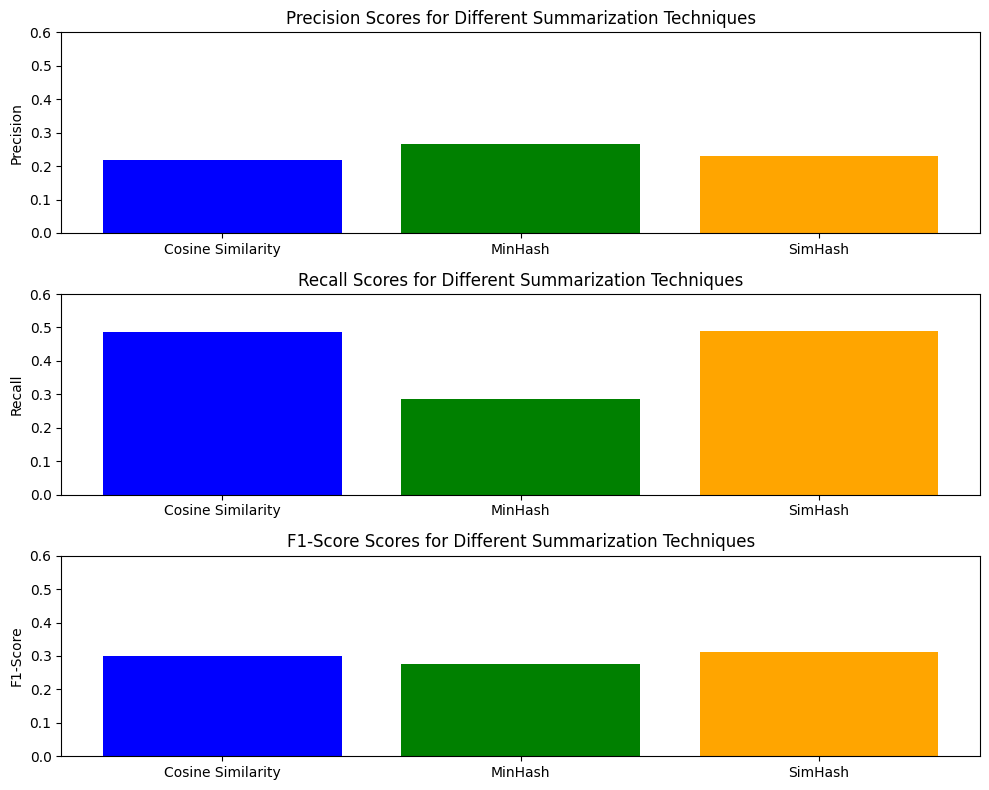

In [1]:
import matplotlib.pyplot as plt

# ROUGE scores for different summarization techniques
techniques = ['Cosine Similarity', 'MinHash', 'SimHash']
metrics = ['Precision', 'Recall', 'F1-Score']

rouge_scores = {
    'Cosine Similarity': {'Precision': 0.218, 'Recall': 0.485, 'F1-Score': 0.301},
    'MinHash': {'Precision': 0.266, 'Recall': 0.286, 'F1-Score': 0.276},
    'SimHash': {'Precision': 0.229, 'Recall': 0.488, 'F1-Score': 0.312}
}

# Plotting bar charts
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 8))

for i, metric in enumerate(metrics):
    ax = axes[i]
    scores = [rouge_scores[technique][metric] for technique in techniques]
    ax.bar(techniques, scores, color=['blue', 'green', 'orange'])
    ax.set_ylabel(metric)
    ax.set_ylim(0, 0.6)  # Adjust the y-axis limit as needed
    ax.set_title(f'{metric} Scores for Different Summarization Techniques')

plt.tight_layout()
plt.show()
